# Pytorch's tutorial on Mask R-CNN

In this notebook, I will try to follow and replicate the tutorial to get some familiarity with transferred learning with Mask R-CNN.

In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from pathlib import Path

### Get COCO API

In [3]:
! git clone https://github.com/cocodataset/cocoapi.git

Cloning into 'cocoapi'...
remote: Enumerating objects: 959, done.
remote: Total 959 (delta 0), reused 0 (delta 0), pack-reused 959
Receiving objects: 100% (959/959), 11.69 MiB | 6.53 MiB/s, done.
Resolving deltas: 100% (570/570), done.


In [7]:
cd cocoapi/PythonAPI/

/home/jupyter/kgl_clouds/cocoapi/PythonAPI


In [9]:
! python setup.py build_ext install

running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/opt/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/jupyter/kgl_clouds/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
gcc -pthread -B /opt/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/anaconda3/lib/python3.7/site-packages/numpy/core/include -I../common -I/opt/anaconda3/include/python3.7m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.7/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ c

removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing pycocotools-2.0-py3.7-linux-x86_64.egg
creating /opt/anaconda3/lib/python3.7/site-packages/pycocotools-2.0-py3.7-linux-x86_64.egg
Extracting pycocotools-2.0-py3.7-linux-x86_64.egg to /opt/anaconda3/lib/python3.7/site-packages
Adding pycocotools 2.0 to easy-install.pth file

Installed /opt/anaconda3/lib/python3.7/site-packages/pycocotools-2.0-py3.7-linux-x86_64.egg
Processing dependencies for pycocotools==2.0
Searching for matplotlib==3.1.0
Best match: matplotlib 3.1.0
Adding matplotlib 3.1.0 to easy-install.pth file

Using /opt/anaconda3/lib/python3.7/site-packages
Searching for Cython==0.29.13
Best match: Cython 0.29.13
Adding Cython 0.29.13 to easy-install.pth file
Installing cygdb script to /opt/anaconda3/bin
Installing cython script to /opt/anaconda3/bin
Installing cythonize script to /opt/anaconda3/bin

Using /opt/anaconda3/lib/python3.7/site-packages
Searching for setuptools==41.0.1
Best match: setuptool

### Install pycocotools

In [18]:
! pip install pycocotools

### Get PennFudanPed dataset

In [4]:
! wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .

--2019-10-21 13:13:21--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  1005KB/s    in 53s     

2019-10-21 13:14:14 (988 KB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2019-10-21 13:14:14--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2019-10-21 13:14:14--
Total wall clock time: 53s
Downloaded: 1 files, 51M in 53s (988 KB/s)


In [5]:
! unzip PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

  inflating: PennFudanPed/PNGImages/FudanPed00001.png  
  inflating: PennFudanPed/PNGImages/FudanPed00002.png  
  inflating: PennFudanPed/PNGImages/FudanPed00003.png  
  inflating: PennFudanPed/PNGImages/FudanPed00004.png  
  inflating: PennFudanPed/PNGImages/FudanPed00005.png  
  inflating: PennFudanPed/PNGImages/FudanPed00006.png  
  inflating: PennFudanPed/PNGImages/FudanPed00007.png  
  inflating: PennFudanPed/PNGImages/FudanPed00008.png  
  inflating: PennFudanPed/PNGImages/FudanPed00009.png  
  inflating: PennFudanPed/PNGImages/FudanPed00010.png  
  inflating: PennFudanPed/PNGImages/FudanPed00011.png  
  inflating: PennFudanPed/PNGImages/FudanPed00012.png  
  inflating: PennFudanPed/PNGImages/FudanPed00013.png  
  inflating: PennFudanPed/PNGImages/FudanPed00014.png  
  inflating: PennFudanPed/PNGImages/FudanPed00015.png  
  inflating: PennFudanPed/PNGImages/FudanPed00016.png  
  inflating: PennFudanPed/PNGImages/FudanPed00017.png  
  inflating: PennFudanPed/PNGImages/FudanPed0001

  inflating: PennFudanPed/PNGImages/PennPed00081.png  
  inflating: PennFudanPed/PNGImages/PennPed00082.png  
  inflating: PennFudanPed/PNGImages/PennPed00083.png  
  inflating: PennFudanPed/PNGImages/PennPed00084.png  
  inflating: PennFudanPed/PNGImages/PennPed00085.png  
  inflating: PennFudanPed/PNGImages/PennPed00086.png  
  inflating: PennFudanPed/PNGImages/PennPed00087.png  
  inflating: PennFudanPed/PNGImages/PennPed00088.png  
  inflating: PennFudanPed/PNGImages/PennPed00089.png  
  inflating: PennFudanPed/PNGImages/PennPed00090.png  
  inflating: PennFudanPed/PNGImages/PennPed00091.png  
  inflating: PennFudanPed/PNGImages/PennPed00092.png  
  inflating: PennFudanPed/PNGImages/PennPed00093.png  
  inflating: PennFudanPed/PNGImages/PennPed00094.png  
  inflating: PennFudanPed/PNGImages/PennPed00095.png  
  inflating: PennFudanPed/PNGImages/PennPed00096.png  
  inflating: PennFudanPed/readme.txt  


### Look at some examples in dataset

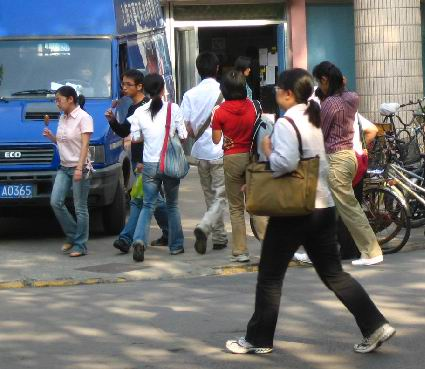

In [7]:
Image.open('PennFudanPed/PNGImages/FudanPed00025.png')

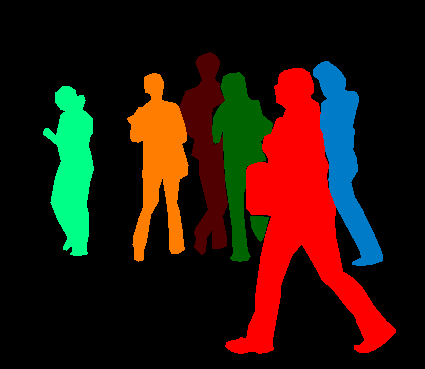

In [3]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00025_mask.png')
mask.putpalette([
    0, 0, 0,
    255, 0, 0,
    0, 255, 135,
    255, 125, 0,
    80, 0, 0,
    0, 100, 0,
    0, 123, 200,
    200, 146, 50])
mask

In [4]:
np.unique(np.array(mask))

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [5]:
mask.size, np.array(mask).shape

((425, 369), (369, 425))

In [6]:
np.array(mask)[180]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [7]:
torch.IntTensor(np.array(mask))[180]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Create Dataset

In [2]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = Path(root)
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(self.root/'PNGImages')))
        self.masks = list(sorted(os.listdir(self.root/'PedMasks')))
        
    def __getitem__(self, idx):
        img_path = self.root/'PNGImages'/self.imgs[idx]
        mask_path = self.root/'PedMasks'/self.masks[idx]
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        
        masks = mask==obj_ids[:,None,None]
        
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        image_id = torch.tensor([idx])
        area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
        
    def __len__(self):
        return len(self.imgs)

In [3]:
dataset = PennFudanDataset('PennFudanPed/')

In [4]:
dataset[35]

(<PIL.Image.Image image mode=RGB size=1017x444 at 0x7F33AAC7D190>,
 {'boxes': tensor([[130.,  97., 278., 393.],
          [801., 119., 936., 380.],
          [243., 132., 329., 362.],
          [725., 144., 788., 344.]]),
  'labels': tensor([1, 1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
         

### An Instance segmentation model for PennFudan Dataset

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [6]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)    

In [7]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign()
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
  (mask_roi_pool): MultiScaleRoIAlign()
  (mask_head): MaskRCNNHeads(
    (mask_fcn1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (mask_fcn2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (mask_fcn3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (mask_fcn4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU(inplace=True)
  )
  (mask_predictor): MaskRCNNPredictor(
    (conv5_mask): ConvTr

In [8]:
model.roi_heads.box_predictor.cls_score.in_features

1024

In [9]:
model.roi_heads.mask_predictor.conv5_mask.in_channels

256

In [10]:
FastRCNNPredictor(150, 3)

FastRCNNPredictor(
  (cls_score): Linear(in_features=150, out_features=3, bias=True)
  (bbox_pred): Linear(in_features=150, out_features=12, bias=True)
)

In [11]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                      hidden_layer,
                                                      num_classes)
    return model

In [12]:
get_instance_segmentation_model(2).roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign()
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
  (mask_roi_pool): MultiScaleRoIAlign()
  (mask_head): MaskRCNNHeads(
    (mask_fcn1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (mask_fcn2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (mask_fcn3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (mask_fcn4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU(inplace=True)
  )
  (mask_predictor): MaskRCNNPredictor(
    (conv5_mask): ConvTrans

### Training and evaluation functions

In [1]:
! git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 5486 (delta 51), reused 59 (delta 41), pack-reused 5402
Receiving objects: 100% (5486/5486), 9.40 MiB | 0 bytes/s, done.
Resolving deltas: 100% (3621/3621), done.


In [36]:
os.chdir('vision')

In [21]:
! git checkout v0.3.0

Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608... version check against PyTorch's CUDA version


In [37]:
! cp references/detection/utils.py ../
! cp references/detection/transforms.py ../
! cp references/detection/coco_eval.py ../
! cp references/detection/engine.py ../
! cp references/detection/coco_utils.py ../

In [13]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [39]:
os.chdir('../')

In [14]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorchTensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Putting everything together

In [15]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4, 
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4, 
    collate_fn=utils.collate_fn)

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [19]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:02:50  lr: 0.000090  loss: 3.5672 (3.5672)  loss_classifier: 0.7563 (0.7563)  loss_box_reg: 0.1544 (0.1544)  loss_mask: 2.6350 (2.6350)  loss_objectness: 0.0151 (0.0151)  loss_rpn_box_reg: 0.0064 (0.0064)  time: 2.8464  data: 0.2631  max mem: 2309
Epoch: [0]  [10/60]  eta: 0:00:46  lr: 0.000936  loss: 1.5616 (2.1255)  loss_classifier: 0.4522 (0.4991)  loss_box_reg: 0.1845 (0.1919)  loss_mask: 0.9227 (1.3969)  loss_objectness: 0.0183 (0.0274)  loss_rpn_box_reg: 0.0087 (0.0103)  time: 0.9313  data: 0.0297  max mem: 2884
Epoch: [0]  [20/60]  eta: 0:00:33  lr: 0.001783  loss: 0.8759 (1.4333)  loss_classifier: 0.2404 (0.3416)  loss_box_reg: 0.1580 (0.1739)  loss_mask: 0.3996 (0.8819)  loss_objectness: 0.0183 (0.0239)  loss_rpn_box_reg: 0.0090 (0.0119)  time: 0.7263  data: 0.0058  max mem: 2911
Epoch: [0]  [30/60]  eta: 0:00:24  lr: 0.002629  loss: 0.5311 (1.1221)  loss_classifier: 0.0934 (0.2573)  loss_box_reg: 0.1309 (0.1604)  loss_mask: 0.2482 (0.6739)  loss_ob

Epoch: [2]  [ 0/60]  eta: 0:00:51  lr: 0.005000  loss: 0.2746 (0.2746)  loss_classifier: 0.0446 (0.0446)  loss_box_reg: 0.0386 (0.0386)  loss_mask: 0.1638 (0.1638)  loss_objectness: 0.0106 (0.0106)  loss_rpn_box_reg: 0.0170 (0.0170)  time: 0.8639  data: 0.1796  max mem: 3680
Epoch: [2]  [10/60]  eta: 0:00:37  lr: 0.005000  loss: 0.1830 (0.1975)  loss_classifier: 0.0279 (0.0352)  loss_box_reg: 0.0190 (0.0210)  loss_mask: 0.1190 (0.1289)  loss_objectness: 0.0010 (0.0023)  loss_rpn_box_reg: 0.0076 (0.0101)  time: 0.7500  data: 0.0199  max mem: 3680
Epoch: [2]  [20/60]  eta: 0:00:30  lr: 0.005000  loss: 0.1901 (0.2131)  loss_classifier: 0.0342 (0.0348)  loss_box_reg: 0.0179 (0.0235)  loss_mask: 0.1214 (0.1419)  loss_objectness: 0.0007 (0.0016)  loss_rpn_box_reg: 0.0096 (0.0113)  time: 0.7622  data: 0.0047  max mem: 3680
Epoch: [2]  [30/60]  eta: 0:00:22  lr: 0.005000  loss: 0.1799 (0.1963)  loss_classifier: 0.0266 (0.0312)  loss_box_reg: 0.0149 (0.0189)  loss_mask: 0.1237 (0.1351)  loss_ob

Epoch: [4]  [ 0/60]  eta: 0:00:58  lr: 0.000500  loss: 0.1370 (0.1370)  loss_classifier: 0.0312 (0.0312)  loss_box_reg: 0.0060 (0.0060)  loss_mask: 0.0928 (0.0928)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0068 (0.0068)  time: 0.9765  data: 0.2420  max mem: 3680
Epoch: [4]  [10/60]  eta: 0:00:37  lr: 0.000500  loss: 0.1763 (0.1739)  loss_classifier: 0.0268 (0.0272)  loss_box_reg: 0.0108 (0.0128)  loss_mask: 0.1237 (0.1252)  loss_objectness: 0.0002 (0.0013)  loss_rpn_box_reg: 0.0062 (0.0073)  time: 0.7529  data: 0.0258  max mem: 3680
Epoch: [4]  [20/60]  eta: 0:00:30  lr: 0.000500  loss: 0.1657 (0.1725)  loss_classifier: 0.0268 (0.0280)  loss_box_reg: 0.0108 (0.0134)  loss_mask: 0.1143 (0.1222)  loss_objectness: 0.0004 (0.0011)  loss_rpn_box_reg: 0.0060 (0.0078)  time: 0.7480  data: 0.0050  max mem: 3819
Epoch: [4]  [30/60]  eta: 0:00:22  lr: 0.000500  loss: 0.1514 (0.1679)  loss_classifier: 0.0267 (0.0266)  loss_box_reg: 0.0073 (0.0132)  loss_mask: 0.1018 (0.1194)  loss_ob

Epoch: [6]  [ 0/60]  eta: 0:01:05  lr: 0.000050  loss: 0.1338 (0.1338)  loss_classifier: 0.0212 (0.0212)  loss_box_reg: 0.0073 (0.0073)  loss_mask: 0.0987 (0.0987)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0065 (0.0065)  time: 1.0984  data: 0.2080  max mem: 3819
Epoch: [6]  [10/60]  eta: 0:00:39  lr: 0.000050  loss: 0.1637 (0.1675)  loss_classifier: 0.0236 (0.0296)  loss_box_reg: 0.0120 (0.0119)  loss_mask: 0.1063 (0.1166)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0067 (0.0088)  time: 0.7840  data: 0.0235  max mem: 3819
Epoch: [6]  [20/60]  eta: 0:00:30  lr: 0.000050  loss: 0.1525 (0.1636)  loss_classifier: 0.0230 (0.0262)  loss_box_reg: 0.0078 (0.0110)  loss_mask: 0.1131 (0.1173)  loss_objectness: 0.0008 (0.0012)  loss_rpn_box_reg: 0.0056 (0.0079)  time: 0.7413  data: 0.0053  max mem: 3819
Epoch: [6]  [30/60]  eta: 0:00:22  lr: 0.000050  loss: 0.1459 (0.1668)  loss_classifier: 0.0196 (0.0268)  loss_box_reg: 0.0058 (0.0119)  loss_mask: 0.1131 (0.1191)  loss_ob

Epoch: [8]  [ 0/60]  eta: 0:00:49  lr: 0.000050  loss: 0.1347 (0.1347)  loss_classifier: 0.0166 (0.0166)  loss_box_reg: 0.0075 (0.0075)  loss_mask: 0.1068 (0.1068)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0036 (0.0036)  time: 0.8283  data: 0.1511  max mem: 3819
Epoch: [8]  [10/60]  eta: 0:00:36  lr: 0.000050  loss: 0.1403 (0.1602)  loss_classifier: 0.0257 (0.0263)  loss_box_reg: 0.0083 (0.0106)  loss_mask: 0.1068 (0.1171)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0046 (0.0060)  time: 0.7356  data: 0.0190  max mem: 3819
Epoch: [8]  [20/60]  eta: 0:00:29  lr: 0.000050  loss: 0.1401 (0.1521)  loss_classifier: 0.0195 (0.0224)  loss_box_reg: 0.0068 (0.0088)  loss_mask: 0.1024 (0.1134)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0053 (0.0067)  time: 0.7401  data: 0.0057  max mem: 3819
Epoch: [8]  [30/60]  eta: 0:00:22  lr: 0.000050  loss: 0.1412 (0.1513)  loss_classifier: 0.0194 (0.0225)  loss_box_reg: 0.0065 (0.0088)  loss_mask: 0.1026 (0.1124)  loss_ob

In [22]:
img, _ = dataset_test[0]

In [26]:
model.eval();

In [27]:
with torch.no_grad(): prediction = model([img.to(device)])

In [28]:
prediction

[{'boxes': tensor([[ 61.2616,  35.9503, 196.5809, 328.4852],
          [276.4177,  21.5721, 291.1494,  73.7327]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9994, 0.8160], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}]

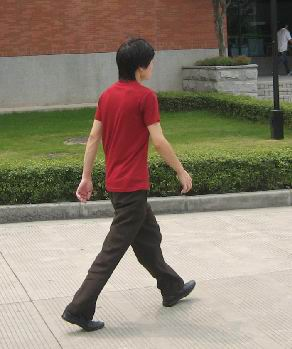

In [39]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

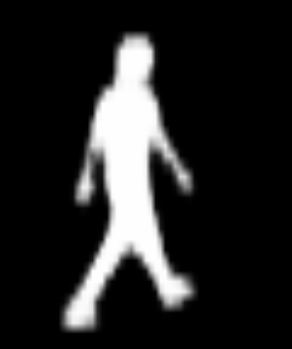

In [56]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

torch.Size([3, 349, 292])

# -FIN